# Signatures of dark companions in Gaia data. 

Using the formalism in Andrew et al, the mass of a dark companion (BH or NS) can be estimated if both RUWE and Radial Velocity error are available. 

Using population synthesis and the astromet software generate mock Gaia data and predict the distribution of companion masses (or mass ratios) for sources in Gaia DR3.

### (Part 2) Gaia DR3 Data

##### **Step 1** - Import GAIA DR3 data RVS - conditions: WHERE 
                                                    radial_velocity_error > 0 
                                                    AND rv_nb_transits > 3 
                                                    AND ruwe > 0 
                                                    AND parallax / parallax_error > 10 
                                                    AND rv_method_used = 1 
                                                    AND bp_rp IS NOT NULL 

##### **Step 2** - Calculate $\sigma_{{b},{vr}}$ & Calculate $\sigma_{{b},{\theta}}$

##### **Step 3** - Import nss_two_body_orbit to include orbital parameters for inference

##### **Step 4** - Merge GAIA DR3 data RVS to nss_two_body_orbit

##### **Step 5** - Calculate $\zeta_0$ and $\beta_0$

##### **Step 6** - Infer P and q

In [1]:
import numpy as np
import pandas as pd
import astropy
from astropy import units as u
import astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import scanninglaw.times
from scanninglaw.source import Source

In [2]:
# import gzip
# import shutil

# # Define the input and output file paths
# input_gz_file = 'data/CommandedScanLaw_001.csv.gz'
# output_csv_file = 'data/CommandedScanLaw_001.csv'

# # Open the gzipped file and write its content to the new CSV file
# with gzip.open(input_gz_file, 'rb') as f_in:
#     with open(output_csv_file, 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

# print(f'File {input_gz_file} has been decompressed to {output_csv_file}')

### Load ScanLaw file

In [3]:
dr3Period=34/12 # Calculate the period in years by dividing 34 by 12
mas=astromet.mas # conversion from degrees to milli-arcseconds

In [4]:
local_csv_filename = "data/CommandedScanLaw_001.csv"

# Load the scanning law times from a local CSV file with the specified filename and version
dr3_sl = scanninglaw.times.Times(map_fname=local_csv_filename, version='dr3_nominal')


Loading auxilliary data ...
t = 27.320 s
  auxilliary:  15.003 s
          sf:   3.258 s
interpolator:   9.058 s


### Import GAIA DR3 data

In [5]:
from astroquery.gaia import Gaia

# Login into ESA Gaia Data Archive (create login if you have not) to run asynchronous queries using your user quota
# credentials file should contain two lines: username and password

# Read more about astroquery and Gaia here:
# https://astroquery.readthedocs.io/en/latest/gaia/gaia.html

# Gaia.login(credentials_file='/Users/vasily/work/python/gaia_archive_credentials')

In [ ]:
# Query Gaia DR3 to select N random sources with given conditions
# ---------------------------------------------------------------
# For n = 1e+6 sources, the query might take ~10-15 min

# n = number of random sources
# mag_lim = limiting magnitude in G
# blim = limiting |b|
# par_sn = threshold in parallax S/N

n = 1000000

# Query
# Make sure that commands inside the query do not stick together, print to check
q = f"""
SELECT TOP {n} source_id, ra, dec, phot_g_mean_mag, bp_rp, parallax, pmra, pmdec, ruwe, 
               radial_velocity_error, rv_method_used, rv_nb_transits, 
               non_single_star, radial_velocity, parallax_error 
FROM gaiadr3.gaia_source 
WHERE radial_velocity_error > 0 
  AND rv_nb_transits > 3 
  AND ruwe > 0 
  AND parallax / parallax_error > 10 
  AND rv_method_used = 1 
  AND bp_rp IS NOT NULL 
ORDER BY source_id
"""

# Run query
job = Gaia.launch_job_async(q)
r = job.get_results()

# Save the query results to a local CSV file
r.write('data/gaia_dr3.csv', overwrite=True)

In [6]:
# load data in a dataframe
gaia = pd.read_csv('data/gaia_dr3.csv')

In [7]:
gaia.columns

Index(['SOURCE_ID', 'ra', 'dec', 'phot_g_mean_mag', 'bp_rp', 'parallax',
       'pmra', 'pmdec', 'ruwe', 'radial_velocity_error', 'rv_method_used',
       'rv_nb_transits', 'non_single_star', 'radial_velocity',
       'parallax_error'],
      dtype='object')

In [8]:
gaia.shape

(1000000, 15)

In [10]:
#check if there is any Nan values in the dataframe
gaia.isnull().sum()

SOURCE_ID                0
ra                       0
dec                      0
phot_g_mean_mag          0
bp_rp                    0
parallax                 0
pmra                     0
pmdec                    0
ruwe                     0
radial_velocity_error    0
rv_method_used           0
rv_nb_transits           0
non_single_star          0
radial_velocity          0
parallax_error           0
dtype: int64

In [9]:
gaia.head()

,SOURCE_ID,ra,dec,phot_g_mean_mag,bp_rp,parallax,pmra,pmdec,ruwe,radial_velocity_error,rv_method_used,rv_nb_transits,non_single_star,radial_velocity,parallax_error
0,2851858288640,45.132144,0.137854,12.356248,0.810369,2.676207,4.722164,18.657223,1.213301,1.722275,1,10,0,36.317192,0.018930
1,3332894779520,45.058168,0.127402,12.511697,1.224066,1.772803,6.436307,-12.966895,1.142625,1.070167,1,11,0,4.390000,0.015665
2,7632157690368,45.034343,0.235390,8.068802,1.134080,5.602294,45.466010,-6.834343,1.380983,0.272844,1,10,2,5.901028,0.031826
3,9281425163264,45.165009,0.200053,10.642890,0.769282,3.800303,6.625746,-53.318974,0.906621,0.592796,1,9,0,-26.799025,0.015949
4,12545600306304,45.234476,0.318152,12.194942,1.019697,4.329846,0.056719,-48.337303,1.215962,1.309670,1,10,0,-48.036938,0.019177


### Calculate the inherent measurement error $\sigma_{spec}$

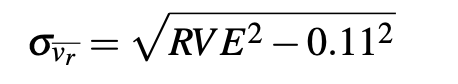

In [11]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/sigma_vr_gaia.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed

In [12]:
# calculate sigma_vr given radial_velocity_error
gaia['sigma_vr'] = np.sqrt((gaia['radial_velocity_error']**2) - (0.11**2))

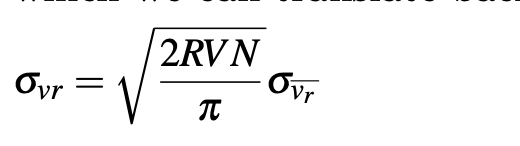

In [73]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/sigma_vr_std.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed

In [14]:
# calculate sigma_vr given rv_nb_transits
gaia['sigma_vr_std'] = np.sqrt(((2*gaia['rv_nb_transits'])/(np.pi))*(gaia['sigma_vr']))

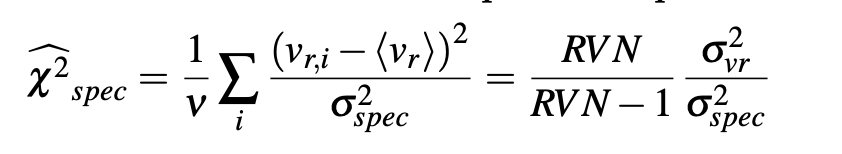

In [15]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/spec_red_chi_sq.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed

In [16]:
initial_sigma_spec = 1 # km/s

# calculate sigma_vr given rv_nb_transits
gaia['chi_2'] = gaia['rv_nb_transits']/(gaia['rv_nb_transits'] - 1) * (gaia['sigma_vr_std']**2)/(initial_sigma_spec**2)

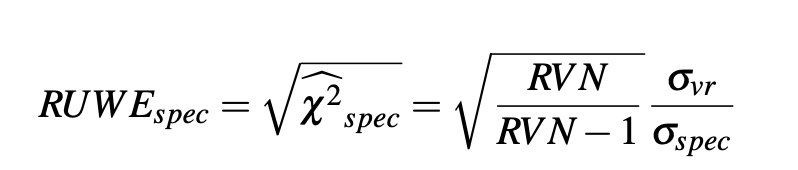

In [17]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/RUWE.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed

In [18]:
initial_sigma_spec = 1 # km/s

# calculate sigma_vr given rv_nb_transits
gaia['RUWE_spec'] = np.sqrt(gaia['rv_nb_transits']/(gaia['rv_nb_transits'] - 1)) * (gaia['sigma_vr_std']/(initial_sigma_spec))


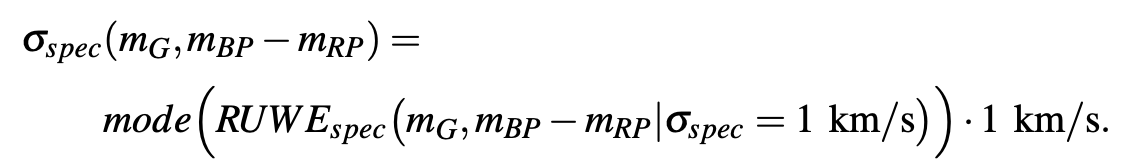

In [19]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/sigma_spec.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed

In [20]:
# calculate the mode of ruwe
gaia['sigma_spec'] = gaia['ruwe'].mode()[0] * (1)


In [21]:
gaia.columns

Index(['SOURCE_ID', 'ra', 'dec', 'phot_g_mean_mag', 'bp_rp', 'parallax',
       'pmra', 'pmdec', 'ruwe', 'radial_velocity_error', 'rv_method_used',
       'rv_nb_transits', 'non_single_star', 'radial_velocity',
       'parallax_error', 'sigma_vr', 'sigma_vr_std', 'chi_2', 'RUWE_spec',
       'sigma_spec'],
      dtype='object')

#### Calculate $\sigma_{{b},{vr}}$

### Calculate astrometic error

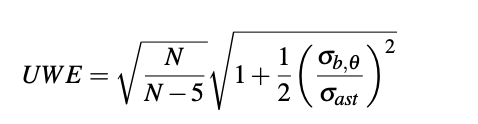

In [74]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/astrometic_error_gaia.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed

#### Calculate $\sigma_{{b},{\theta}}$

### Cross match sample with nss_two_body_orbit dataset containing orbital parameters 

In [33]:
# Query Gaia DR3 to select N random sources with given conditions
# ---------------------------------------------------------------
# For n = 1e+6 sources, the query might take ~10-15 min

# n = number of random sources
# mag_lim = limiting magnitude in G
# blim = limiting |b|
# par_sn = threshold in parallax S/N

n = 1000000

# Query
# Make sure that commands inside the query do not stick together, print to check
q = f"""
SELECT TOP {n} dec, period, arg_periastron, source_id, pmdec, center_of_mass_velocity, \
               nss_solution_type, t_periastron, \
               ra, semi_amplitude_primary, inclination, pmra, eccentricity \
FROM gaiadr3.nss_two_body_orbit 
ORDER BY source_id
"""

# Run query
job = Gaia.launch_job_async(q)
r = job.get_results()

# Save the query results to a local CSV file
r.write('data/nss_two_body_orbit.csv', overwrite=True)

INFO: Query finished. [astroquery.utils.tap.core]


In [34]:
# load data in a dataframe
nss_two_body_orbit = pd.read_csv('data/nss_two_body_orbit.csv')

In [35]:
nss_two_body_orbit.shape

(443205, 16)

In [36]:
#check if there is any Nan values in the dataframe
nss_two_body_orbit.isnull().sum()

dec                        273978
period                          0
arg_periastron             170175
SOURCE_ID                       0
pmdec                      273978
center_of_mass_velocity    222678
nss_solution_type               0
t_periastron                    0
mass_ratio                 443050
mass_ratio_error           443202
ra                         273978
semi_amplitude_primary     256145
inclination                356132
pmra                       273978
eccentricity                  948
g_luminosity_ratio         356132
dtype: int64

In [48]:
# creat a new dataframe including all columns by nss_two_body_orbit and gaia matched on SOURCE_ID, include all columns from nss_two_body_orbit and gaia
nss_gaia = pd.merge(nss_two_body_orbit, gaia, on='SOURCE_ID', how='inner')

# put SOURCE_ID as the first column
nss_gaia = nss_gaia[['SOURCE_ID'] + [col for col in nss_gaia.columns if col != 'SOURCE_ID']]

# rename ruwe as RUWE_ast
nss_gaia.rename(columns={'ruwe': 'RUWE_ast'}, inplace=True)

nss_gaia = nss_gaia.dropna(subset=['g_luminosity_ratio'])
nss_gaia = nss_gaia.dropna(subset=['mass_ratio'])
nss_gaia.shape

(27, 35)

In [49]:
nss_gaia.columns

Index(['SOURCE_ID', 'dec_x', 'period', 'arg_periastron', 'pmdec_x',
       'center_of_mass_velocity', 'nss_solution_type', 't_periastron',
       'mass_ratio', 'mass_ratio_error', 'ra_x', 'semi_amplitude_primary',
       'inclination', 'pmra_x', 'eccentricity', 'g_luminosity_ratio', 'ra_y',
       'dec_y', 'phot_g_mean_mag', 'bp_rp', 'parallax', 'pmra_y', 'pmdec_y',
       'RUWE_ast', 'radial_velocity_error', 'rv_method_used', 'rv_nb_transits',
       'non_single_star', 'radial_velocity', 'parallax_error', 'sigma_vr',
       'sigma_vr_std', 'chi_2', 'RUWE_spec', 'sigma_spec'],
      dtype='object')

In [50]:
nss_two_body_orbit.columns

Index(['dec', 'period', 'arg_periastron', 'SOURCE_ID', 'pmdec',
       'center_of_mass_velocity', 'nss_solution_type', 't_periastron',
       'mass_ratio', 'mass_ratio_error', 'ra', 'semi_amplitude_primary',
       'inclination', 'pmra', 'eccentricity', 'g_luminosity_ratio'],
      dtype='object')

In [51]:
gaia.columns

Index(['SOURCE_ID', 'ra', 'dec', 'phot_g_mean_mag', 'bp_rp', 'parallax',
       'pmra', 'pmdec', 'ruwe', 'radial_velocity_error', 'rv_method_used',
       'rv_nb_transits', 'non_single_star', 'radial_velocity',
       'parallax_error', 'sigma_vr', 'sigma_vr_std', 'chi_2', 'RUWE_spec',
       'sigma_spec'],
      dtype='object')

In [52]:
#check if there is any Nan values in the dataframe
nss_gaia.isnull().sum()

SOURCE_ID                   0
dec_x                      27
period                      0
arg_periastron              0
pmdec_x                    27
center_of_mass_velocity     0
nss_solution_type           0
t_periastron                0
mass_ratio                  0
mass_ratio_error           27
ra_x                       27
semi_amplitude_primary      0
inclination                 0
pmra_x                     27
eccentricity                0
g_luminosity_ratio          0
ra_y                        0
dec_y                       0
phot_g_mean_mag             0
bp_rp                       0
parallax                    0
pmra_y                      0
pmdec_y                     0
RUWE_ast                    0
radial_velocity_error       0
rv_method_used              0
rv_nb_transits              0
non_single_star             0
radial_velocity             0
parallax_error              0
sigma_vr                    0
sigma_vr_std                0
chi_2                       0
RUWE_spec 

### Filter out based on RUWE

In [ ]:
# # filter out nss_gaia with RUWEast > 1.25 and RUWEspec > 2
# nss_gaia = nss_gaia[(nss_gaia['RUWE_ast'] <= 1.25) & (nss_gaia['RUWE_spec'] <= 2)]

### Spectroscopic and Astrometric error calculation for case N <= B

### Calculate $\zeta_0$ (P = B)

##### this result agrees well for all P < B but deviates at longer periods - Andrew et al

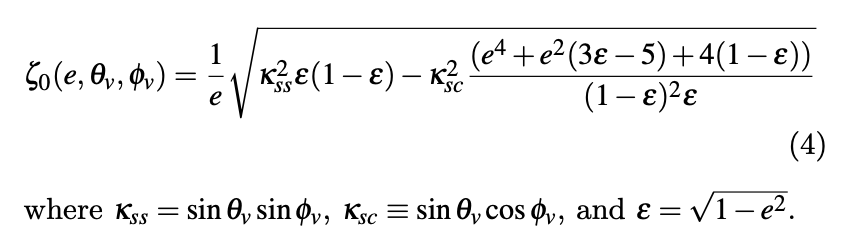

In [53]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/zeta_0.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed


In [54]:
# write a function that calculates the values of zeta_0 for a given set of parameters e, vtheta, vphi
# in terms of e, k_ss = sin(vtheta)sin(vphi), k_sc = sin(vtheta)cos(vphi) and epsilon = sqrt(1-e^2)
def zeta_0(ecc, vTheta, vPhi):
    k_ss = np.sin(vTheta)*np.sin(vPhi)
    k_sc = np.sin(vTheta)*np.cos(vPhi)
    epsilon = np.sqrt(1-ecc**2)

    term_1 = (1/ecc)
    term_2 = (k_ss**2)*epsilon*(1-epsilon)
    term_3 = (k_sc**2)*(((ecc**4)-(ecc**2)*(3*epsilon-5)+4*(1-epsilon))/(((1-epsilon)**2)*epsilon))

    ################### TOOK THE ABS VALUE TO AVOID SQRT OF NEGATIVE NUMBER #######################
    zeta = term_1 * np.sqrt(np.abs(term_2 - term_3))
    return zeta

###### is arg_periastron Phi_nu? ######
nss_gaia.loc[:, 'zeta_0'] = zeta_0(nss_gaia['eccentricity'], nss_gaia['inclination'], nss_gaia['arg_periastron'])

### Calculate $\beta_0$ (P = B)

##### this result agrees well for all P < B but deviates at longer periods - Andrew et al

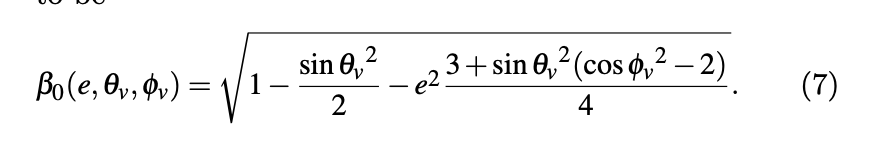

In [55]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/beta_0.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed


In [56]:
# write a function that calculates the values of zeta_0 for a given set of parameters e, vtheta, vphi
# in terms of e, k_ss = sin(vtheta)sin(vphi), k_sc = sin(vtheta)cos(vphi) and epsilon = sqrt(1-e^2)
def beta_0(ecc, vTheta, vPhi):

    term_1 = (np.sin(vTheta)**2)/2
    term_2 = (ecc**2)*(3+(np.sin(vTheta)**2)*((np.cos(vPhi)**2)-2))/4

    beta = np.sqrt(1-term_1 - term_2)
    return beta

# Use .loc to avoid SettingWithCopyWarning
nss_gaia.loc[:, 'beta_0'] = beta_0(nss_gaia['eccentricity'], nss_gaia['inclination'], nss_gaia['arg_periastron'])


# Calculate inferred P and q 

### assume $\sigma_{ast}$ = 0.3 and $\sigma_{spec}$ = 1

In [63]:
nss_gaia.columns

Index(['SOURCE_ID', 'dec_x', 'period', 'arg_periastron', 'pmdec_x',
       'center_of_mass_velocity', 'nss_solution_type', 't_periastron',
       'mass_ratio', 'mass_ratio_error', 'ra_x', 'semi_amplitude_primary',
       'inclination', 'pmra_x', 'eccentricity', 'g_luminosity_ratio', 'ra_y',
       'dec_y', 'phot_g_mean_mag', 'bp_rp', 'parallax', 'pmra_y', 'pmdec_y',
       'RUWE_ast', 'radial_velocity_error', 'rv_method_used', 'rv_nb_transits',
       'non_single_star', 'radial_velocity', 'parallax_error', 'sigma_vr',
       'sigma_vr_std', 'chi_2', 'RUWE_spec', 'sigma_spec', 'zeta_0', 'beta_0',
       'sigma_spectroscopic_error', 'sigma_astrometric_error'],
      dtype='object')

In [64]:
# sigma_ast = 0.3
# sigma_spec = 1

# nss_gaia['UWE_ast'] = np.sqrt(nss_gaia['N_obs']/(nss_gaia['N_obs']-5)) * np.sqrt(1 + ((1/2)*(nss_gaia['sigma_astrometric_error']/sigma_ast)**2))
# nss_gaia['UWE_spec'] = np.sqrt(nss_gaia['N_obs']/(nss_gaia['N_obs']-5)) * np.sqrt(1 + ((1/2)*(nss_gaia['sigma_spectroscopic_error']/sigma_ast)**2))

# # filter out the df cased on UWEast < 1.25 and UWEspec < 2
# nss_gaia = nss_gaia[(nss_gaia['UWE_ast'] < 1.25) & (nss_gaia['UWE_spec'] < 2)]

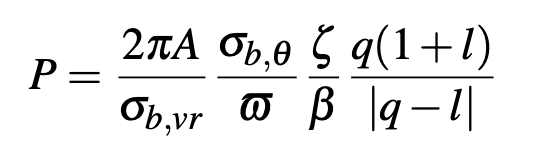

In [65]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/inferred_P.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed

In [66]:
nss_gaia.columns

Index(['SOURCE_ID', 'dec_x', 'period', 'arg_periastron', 'pmdec_x',
       'center_of_mass_velocity', 'nss_solution_type', 't_periastron',
       'mass_ratio', 'mass_ratio_error', 'ra_x', 'semi_amplitude_primary',
       'inclination', 'pmra_x', 'eccentricity', 'g_luminosity_ratio', 'ra_y',
       'dec_y', 'phot_g_mean_mag', 'bp_rp', 'parallax', 'pmra_y', 'pmdec_y',
       'RUWE_ast', 'radial_velocity_error', 'rv_method_used', 'rv_nb_transits',
       'non_single_star', 'radial_velocity', 'parallax_error', 'sigma_vr',
       'sigma_vr_std', 'chi_2', 'RUWE_spec', 'sigma_spec', 'zeta_0', 'beta_0',
       'sigma_spectroscopic_error', 'sigma_astrometric_error'],
      dtype='object')

In [67]:
# Calculate inferred P
def inferred_P(A, sigma_spectroscopic_error, sigma_astrometric_error, omega, zeta_0, beta_0):
    term_1 = (2*np.pi*A)/sigma_spectroscopic_error
    term_2 = sigma_astrometric_error/omega
    term_3 = zeta_0/beta_0
    return term_1*term_2*term_3

# Use .loc to avoid SettingWithCopyWarning
nss_gaia.loc[:, 'inferred_P'] = inferred_P(
    AU, 
    nss_gaia['sigma_spectroscopic_error'], 
    nss_gaia['sigma_astrometric_error'], 
    nss_gaia['parallax'], 
    nss_gaia['zeta_0'], 
    nss_gaia['beta_0'] 
)

In [68]:
nss_gaia['parallax']

3054     1.484877
7162     1.355581
7967     1.296571
11124    1.299361
12042    1.102585
13871    1.350574
15164    1.527944
16571    1.242418
18450    1.305743
18504    3.536403
21820    0.868117
22779    1.394991
22936    0.743686
23824    1.531923
25238    2.128356
25497    1.321001
26059    3.344398
33908    1.820397
34531    3.750177
36257    1.852008
36928    1.400609
37006    2.426535
42405    2.670511
43590    1.787850
44214    3.281260
44379    1.585561
44640    1.246610
Name: parallax, dtype: float64

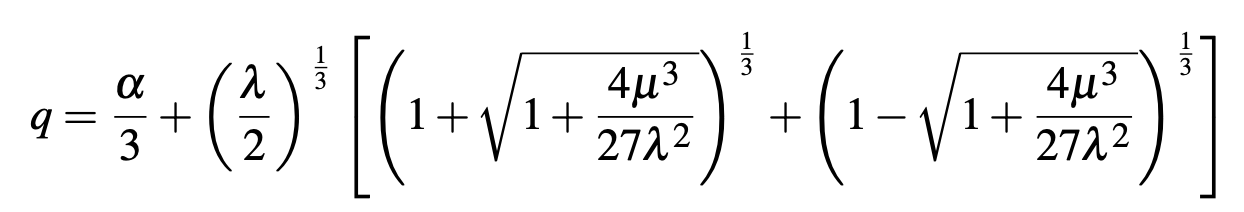

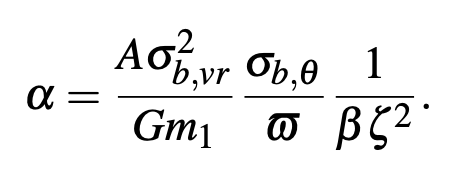

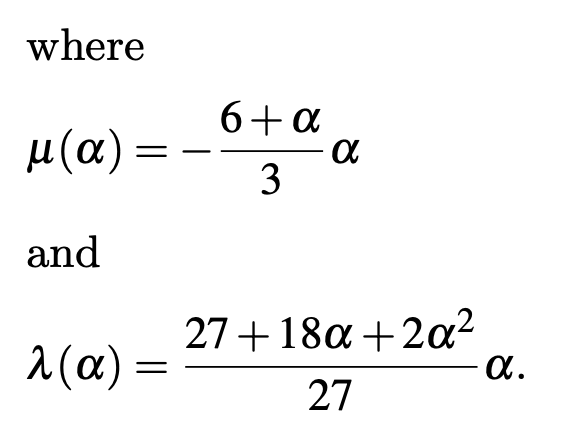

In [69]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/inferred_q.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed

# Display an image from a local file with specified size
img_path = 'images/solve_q_1.png'
display(Image(filename=img_path, width=150, height=100))  # Adjust width and height as needed

# Display an image from a local file with specified size
img_path = 'images/solve_q_2.png'
display(Image(filename=img_path, width=150, height=100))  # Adjust width and height as needed

In [70]:
############# Porblem with Mass_1, it is not defined in the code ##############################
m_1 = 1.989e+30

def solve_q(A, sigma_spectroscopic_error, sigma_astrometric_error, parallax, zeta_0, beta_0, m_1):
    G = astromet.Galt

    alpha = ((A * (sigma_spectroscopic_error**2)) / (G * m_1)) * (sigma_astrometric_error / parallax) * 1 / (beta_0 * zeta_0**2)
    mu = - ((6 + alpha) / 3) * alpha
    lam = ((27 + 18 * alpha + 2 * alpha**2) / 27) * alpha

    q = (alpha / 3) + ((lam / 2)**(1/3)) * (
        (1 + np.sqrt(1 + (4 * mu**3) / (27 * lam**2)))**(1/3) + 
        (1 - np.sqrt(1 + (4 * mu**3) / (27 * lam**2)))**(1/3)
    )

    return q

# Define AU
AU = 1.496e+11

# Apply the function to each row in the DataFrame using .loc to avoid SettingWithCopyWarning
nss_gaia.loc[:, 'inferred_q'] = nss_gaia.apply(
    lambda row: solve_q(AU, row['sigma_spectroscopic_error'], row['sigma_astrometric_error'], row['parallax'], row['zeta_0'], row['beta_0'], m_1),
    axis=1
)

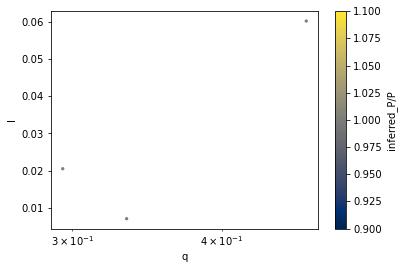

In [71]:
# plot on the x axis q and on the y axis l and colormap the points by inferred_P/P with small points and name the colorbar
# i want the color map thats really colorful
# not a scatter plot i want it smooth
# use a colormap that goes from blue to red
plt.scatter(nss_gaia['mass_ratio'], nss_gaia['g_luminosity_ratio'], c=nss_gaia['inferred_P']/nss_gaia['period'], cmap='cividis', s=5)
plt.xlabel('q')
plt.ylabel('l')
plt.xscale('log')
plt.colorbar(label='inferred_P/P')
plt.show()

In [ ]:
nss_gaia['mass_ratio']

In [ ]:
nss_gaia['g_luminosity_ratio']

In [ ]:
nss_gaia['inferred_P']

In [ ]:
nss_gaia['period']